# __Sentiment Analysis of Restaurant Reviews: Unveiling Customer Perceptions__

## Introduction:

<div style="text-align: justify;">  
In today's digital age, where online platforms and social media have become integral parts of our daily lives, customer reviews wield significant influence over the success and reputation of businesses, particularly within the competitive landscape of the restaurant industry. These reviews serve as a direct channel for customers to express their opinions, share experiences, and provide feedback, making them a valuable source of insights for restaurant owners and managers. Understanding the sentiment expressed in these reviews can provide valuable insights to improve their services, identify areas of strength, and address customer concerns. Positive reviews can act as endorsements, attracting new customers and fostering loyalty among existing ones. Conversely, negative reviews have the potential to damage restaurant's reputation, resulting in loss of business and damage to brand image. Therefore, understanding the sentiment expressed in these reviews is paramount for businesses seeking to thrive.</div>

<div style="text-align: justify;">
The objective of this project is to analyze customer sentiment in restaurant reviews and explore its relationship with various factors, including price range. Initially, the sentiment of each review is categorized as either positive or average based on customer ratings. Subsequently, the reviews are tokenized and preprocessed to prepare them for machine learning analysis. Using techniques like oversampling with SMOTE and a deep learning model comprising layers of embeddings, sentiment analysis is performed to predict sentiment from review text.

Additionally, the association between sentiment and price range is investigated through clustering using K-means algorithm. The methodology integrates data preprocessing, machine learning, and exploratory analysis to gain insights into customer sentiment and its drivers in the restaurant industry.
</div>

### 1. Load the Libraries

In [1]:
# pip install tensorflow==2.15.0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import nltk
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHREY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SHREY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 2. Read data

<div style="text-align: justify;">
The 'TA_restaurants_curated1.csv' dataset was compiled by scraping data from the Trip Advisor website to gather information about restaurants across various cities. After collecting raw data from major cities in Europe, it is preprocessed to produce the final dataset. It includes restaurant details from 31 cities across Europe.
    </div>

In [2]:
# Load the data
restReviews = pd.read_csv("TA_restaurants_curated1.csv")

### 3. Pre-processing

In [3]:
restReviews.head(3)

,Unnamed: 0,Name,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",1.0,5.0,$$ - $$$,136.0,"[['Just like home', 'A Warm Welcome to Wintry Amsterdam'], ['01/03/2018', '01/01/2018']]",/Restaurant_Review-g188590-d11752080-Reviews-Martine_of_Martine_s_Table-Amsterdam_North_Holland_Province.html,d11752080
1,1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', 'Gluten Free Options']",2.0,4.5,$$$$,812.0,"[['Great food and staff', 'just perfect'], ['01/06/2018', '01/04/2018']]",/Restaurant_Review-g188590-d693419-Reviews-De_Silveren_Spiegel-Amsterdam_North_Holland_Province.html,d693419
2,2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', 'European', 'Vegetarian Friendly', 'Vegan Options']",3.0,4.5,$$$$,567.0,"[['Satisfaction', 'Delicious old school restaurant'], ['01/04/2018', '01/04/2018']]",/Restaurant_Review-g188590-d696959-Reviews-La_Rive-Amsterdam_North_Holland_Province.html,d696959


In [4]:
# Renaming the columns 
restReviews.rename(columns={"Name":"name","City":"city",
                            "Cuisine Style" : "cuisine",'Rating':'rating',
                            "Price Range": "priceRange", 
                            "Number of Reviews" : "numOfReviews",
                            "Reviews":'reviews'}, inplace = True)

- __Removing Duplicates__

    According to the dataset, each row is uniquely identified by the 'ID_TA' column. However, there are some duplicate values in this column. We'll remove these duplicates to ensure data integrity.

In [5]:
restReviews.drop_duplicates(['ID_TA'], keep='first', inplace=True)

#Dropping the columns which are not required.
restReviews.drop(["Unnamed: 0","Ranking", "URL_TA", "ID_TA"], axis = 1, 
                 inplace = True)

- __Handling Missing Values__
   
   The cuisine column should be handled for missing values. The 'transform' method is used to handle missing or incomplete data in the 'cuisine' column. It converts the string representation of a list of cuisines into an actual list. If the conversion fails due to syntax or value errors, it returns an empty string. This ensures accurate representation of cuisine information and addresses missing or incomplete values.



In [6]:
# Function to transform each element of the Cuisine column
def transform(element):
    try:
        # Convert string representation of list to actual list
        element = ast.literal_eval(element)  
        # Join elements of the list with comma separation
        text = ', '.join(element)  
    except (SyntaxError, ValueError):
        text = ""  # Return empty string if unable to evaluate the line
    return text

# Applying the function to the Cuisine column
restReviews['cuisine'] = restReviews['cuisine'].apply(transform)

<div style="text-align: justify;">
The number of empty strings in the 'cuisine' column is calculated below. The missing cuisine values are inferred based on restaurant names. If a restaurant name contains a substring that matches a cuisine, the corresponding missing value is updated. Any remaining missing cuisine values are then filled with 'Other'.
    </div>

In [7]:
empty_string_count = (restReviews['cuisine'] == '').sum()
print(empty_string_count)

31279


In [8]:
# Initialize an empty dictionary to store cuisine frequencies
cuisine_list = {}

# Iterate over each entry in the 'cuisine' column
for i in restReviews.cuisine:
    arr = i.split(",")
    for j in range(len(arr)):
        #  If the cuisine already exists, increment its count
        if arr[j] in cuisine_list:
            cuisine_list[arr[j]] += 1
        # Else, add it to the dictionary with a count of 1
        else:
            cuisine_list[arr[j]] = 1
            
# Update missing cuisine values based on restaurant names
for i in cuisine_list:
    restReviews.loc[(restReviews.name.str.lower().str.contains(i.lower())
                     & (restReviews.cuisine == "")), "cuisine"] = i
# Fill remaining missing cuisine values with 'Other'
restReviews.loc[restReviews['cuisine'] == '', 'cuisine'] = 'Other'

Impute missing values in the 'Rating' column by replacing them with the mode value calculated for each group defined by the combination of 'city', 'cuisine', and 'priceRange'. 

In [9]:
# Fill missing values in the 'rating' column
mode_rating = restReviews.groupby(["city", "cuisine", "priceRange"])["rating"].agg(pd.Series.mode).values[0]
restReviews['rating'].fillna(mode_rating, inplace=True)

# Fill missing values in the 'numOfReviews' column with 0
restReviews['numOfReviews'].fillna(0, inplace=True)

# Dropping rows with missing reviews
restReviews.dropna(subset=['reviews'], inplace=True)

- __Data Formatting__

    We'll replace the notation used in the dataset for the three price ranges with more suitable labels: cheaper, medium and higher respectively. Additionally, replacing the NaN values with 'notAvailable' to indicate missing price range

In [10]:
restReviews["priceRange"].unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

In [11]:
# Replacing price range with cheaper, medium and higher.
restReviews.replace({"$": 'cheaper', "$$ - $$$": 'medium', "$$$$": 'higher'}, inplace = True)
restReviews['priceRange'].fillna('notAvailable', inplace=True)
# Converting the 'numOfReviews' column to integers
restReviews['numOfReviews'] = restReviews['numOfReviews'].astype('int')

Creating a copy of the DataFrame for further processing.

In [12]:
copyReviews=restReviews.copy()

<div style="text-align: justify;">
The original format of the review data in the 'reviews' column consists of nested lists. Each element of this nested list contains two sub-lists: one for the review text and another for the corresponding date. However, for the purpose of our model, we only require the review text. Therefore, we have extracted only the review text from this nested structure.
    </div>

In [13]:
def parse_nested_list(s):
    # Remove the extra brackets and quotes
    s = s.strip("[]")
    # Split the string to extract reviews part
    parts = s.split("'], [")
    # Extract reviews
    review_list = ', '.join([review.strip("'") for review in parts[0].split("', '")])
    if not review_list:
        review_list = 'No review available'
    return review_list

# Apply the function to parse the nested list in the 'reviews' column
copyReviews['review'] = copyReviews['reviews'].apply(parse_nested_list)
copyReviews.drop(columns=['reviews'], inplace=True)

# Filter out rows
copyReviews = copyReviews[copyReviews['review'].apply(lambda x: len(x) > 3)]


<div style="text-align: justify;">
One-hot encoding was applied to the 'priceRange' column to convert categorical price range data into binary vectors, where each category is represented by a binary variable format suitable for machine learning models. This preprocessing step enhances the model's ability to learn from the data and improves its overall performance. 
    </div>

In [14]:
# One-hot encode the 'Price Range' column
price_dummies = pd.get_dummies(copyReviews['priceRange'], prefix='price')

# Concatenate the original DataFrame with the dummy variables
copyReviews = pd.concat([copyReviews, price_dummies], axis=1)
# Drop the original 'priceRange' column
copyReviews.drop(columns=['priceRange'], inplace=True)

<div style="text-align: justify;">
Sentiment labels were assigned to the reviews based on their ratings. Reviews with ratings equal to or greater than 3.5 were labeled as positive sentiments, while those with ratings below 3.5 were labeled as average sentiments. This process helps categorize the reviews into positive and average sentiment categories, which can be useful for sentiment analysis and classification tasks.
    </div>

In [15]:
from sklearn.preprocessing import LabelEncoder
def label_sentiment(rating):
    if rating >= 3.5:
        return 1
    else:
        return 0

# Apply the function to label sentiments based on ratings
copyReviews['sentiment'] = copyReviews['rating'].apply(label_sentiment)


- Tokenization and Padding: 

    <div style="text-align: justify;">The text data, consisting of customer reviews, undergoes tokenization, which involves breaking down the text into individual words or tokens. This process is essential for the model to understand and process the textual data. Additionally, padding is applied to ensure that all sequences have the same length, which is necessary for the model's input layer to process the data efficiently.</div>
<div style="text-align: justify;">
In the below step, we utilize Keras's Tokenizer and sequence padding functionalities to preprocess the text data. The Tokenizer is initialized to tokenize the reviews, removing punctuations and special characters. It further limits the vocabulary size to the top 20,000 words. Subsequently, the reviews are tokenized into sequences and padded to ensure uniform length using a maximum sequence length of 60.
    </div>

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', num_words=20000)

all_reviews = copyReviews["review"].astype(str).to_list()
# Fit tokenizer on the reviews
tokenizer.fit_on_texts(all_reviews)

# Create DataFrame with word frequencies
words = pd.DataFrame.from_dict(tokenizer.word_counts, orient="index", columns=["frequency"])

# Tokenize and pad sequences
sequences = tokenizer.texts_to_sequences(all_reviews)
padded_sequence = pad_sequences(sequences, maxlen=30, padding='post', truncating='post')
# Add padded sequences to DataFrame
copyReviews["sequences"] = list(padded_sequence)

In [17]:
copyReviews.head(2)

,name,city,cuisine,rating,numOfReviews,review,price_cheaper,price_higher,price_medium,price_notAvailable,sentiment,sequences
0,Martine of Martine's Table,Amsterdam,"French, Dutch, European",5.0,136,"Just like home, A Warm Welcome to Wintry Amsterdam",False,False,True,False,1,"[68, 120, 142, 5, 217, 300, 16, 6289, 392, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,De Silveren Spiegel,Amsterdam,"Dutch, European, Vegetarian Friendly, Gluten Free Options",4.5,812,"Great food and staff, just perfect",False,True,False,False,1,"[3, 1, 4, 35, 68, 52, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


### 3. Data Exploration



<div style="text-align: justify;">
                                                                                                                              
This exploration provides an initial understanding of the dataset's structure and the type of information it contains. Further study can reveal more insights about the restaurants and their attributes.
The dataset contains information about restaurants, including their name, city, cuisine style, ranking, rating, price range, number of reviews, reviews, URL on TripAdvisor, and TripAdvisor ID.

</div>

In [18]:
# Displaying summary information about the restReviews DataFrame
copyReviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96636 entries, 0 to 125451
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                96636 non-null  object 
 1   city                96636 non-null  object 
 2   cuisine             96636 non-null  object 
 3   rating              96636 non-null  float64
 4   numOfReviews        96636 non-null  int32  
 5   review              96636 non-null  object 
 6   price_cheaper       96636 non-null  bool   
 7   price_higher        96636 non-null  bool   
 8   price_medium        96636 non-null  bool   
 9   price_notAvailable  96636 non-null  bool   
 10  sentiment           96636 non-null  int64  
 11  sequences           96636 non-null  object 
dtypes: bool(4), float64(1), int32(1), int64(1), object(5)
memory usage: 6.6+ MB


- __Create histogram for ratings__

    This plot gives an overview of how ratings are distributed across the dataset, providing insights into the distribution of customer ratings for restaurants.

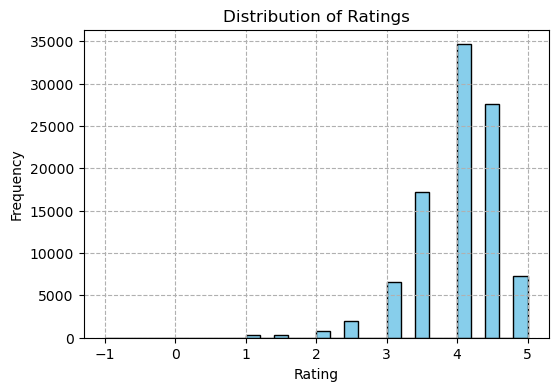

In [19]:
# Filter out rows with missing values in the 'Rating' column
filtered_reviews = copyReviews['rating'].dropna()

plt.figure(figsize=(6, 4))
plt.hist(filtered_reviews, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--')
plt.show()

The histogram above illustrates the distribution of ratings in the dataset, showcasing the frequency of different rating values. With a peak towards higher ratings, particularly at 3.5, 4, and 4.5 stars, it's evident that a significant proportion of the reviewed restaurants have received positive ratings.

In [20]:
# Relative frequencies of Ratings
copyReviews["rating"].value_counts(normalize=True).sort_values(ascending=False)

rating
 4.0    0.358293
 4.5    0.285380
 3.5    0.178236
 5.0    0.075355
 3.0    0.067470
 2.5    0.020779
 2.0    0.008734
 1.0    0.002866
 1.5    0.002763
-1.0    0.000124
Name: proportion, dtype: float64

<div style="text-align: justify;">The distribution of restaurant ratings in the dataset reveals a notable skew towards positive reviews. Over 70% of ratings are 3.5 stars or higher, indicating a general inclination towards positive feedback. Conversely, extreme negative ratings are relatively rare, collectively comprising less than 2% of the dataset. This suggests that while positive experiences are common, extremely negative experiences are less frequent. Further exploration may uncover additional insights into the underlying factors influencing these ratings and potential biases in the review process.</div>

- __Analysis of Review Texts by Rating__

<div style="text-align: justify;">
    
In analyzing the reviews, we tokenized the text and removed stopwords to focus on meaningful words. For ratings of particular interest, we printed the most common words associated with each rating. This approach allowed us to identify prevalent themes or sentiments expressed in reviews across different rating categories.</div>

In [21]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Tokenize the reviews and remove stopwords
stop_words = set(stopwords.words('english'))

# Dictionary to store word counts for each rating
word_counts = {rating: Counter() for rating in copyReviews['rating'].unique()}
for index, row in copyReviews.iterrows():
    rating = row['rating']
    review = row['review']
    tokens = word_tokenize(review.lower())
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    word_counts[rating].update(filtered_tokens)

ratings_of_interest = [5.0, 3.0, 1.0]
# Print the most common words for rating
for rating, counts in word_counts.items():
    if rating in ratings_of_interest:
        print(f"Rating: {rating}")
        print(counts.most_common(5))
        print()

Rating: 5.0
[('great', 2066), ('food', 1724), ('best', 1195), ('place', 997), ('good', 749)]

Rating: 3.0
[('food', 1696), ('good', 1659), ('service', 863), ('great', 840), ('nice', 789)]

Rating: 1.0
[('food', 45), ('worst', 34), ('service', 33), ('terrible', 27), ('avoid', 25)]



<div style="text-align: justify;">
The most common words associated with different ratings are identified. For instance, among reviews rated 5.0, terms like 'great', 'food', and 'best' are frequently used, indicating highly positive experiences. On the other hand, reviews rated 1.0 often include terms like 'worst', 'terrible', and 'avoid', indicating extremely negative experiences. Understanding these patterns provides insights into customers' sentiments and preferences regarding restaurant experiences at different rating levels.
    </div>

<div style="text-align: justify;">
The sentiment labeling process involves categorizing reviews based on their associated ratings. By doing so, it enables an examination of the sentiment distribution within the dataset. This analysis yields valuable insights into the overall sentiment distribution, facilitating a deeper understanding of customer perceptions and satisfaction levels.
    </div>

In [22]:
positive = len(copyReviews[copyReviews["sentiment"]==1])
average = len(copyReviews[copyReviews["sentiment"]==0])
total = len(copyReviews)

print("Positive sentiment: ",str(positive),"reviews (",str(round(positive/total*100,2)),"% )")
print("Average sentiment: ",str(average),"reviews (",str(round(average/total*100,2)),"% )")

Positive sentiment:  86708 reviews ( 89.73 % )
Average sentiment:  9928 reviews ( 10.27 % )


Based on the above output, it can be observed that the majority of reviews are classified as having a positive sentiment. Specifically, there are 86,708 reviews (89.73%) categorized as positive sentiment, while 9,928 reviews (10.27%) are classified as average sentiment. This indicates a predominance of positive perceptions among the reviews analyzed.

## Method
### Classifier based on Artificial Neural Networks

<div style="text-align: justify;">
Classifier based on Artificial Neural Networks (ANNs) for sentiment analysis involves constructing a neural network architecture within a Sequential model, a standard approach facilitated by the Keras library in Python. They consist of interconnected nodes, or neurons, organized in layers. ANNs have gained popularity in machine learning and artificial intelligence for their ability to learn complex patterns and relationships from data. The process begins with tokenized word representations, requiring additional layers within the network to handle this integer-based input.</div>


<div style="text-align: justify;">
Data is split into training and testing sets, which is essential for training and evaluating the machine learning model. The features (X) consist of the padded sequences of tokenized reviews, while the target variable (y) represents the sentiment labels. The data is divided, with a test size of 20% and a specified random state for reproducibility.</div>

In [23]:
from sklearn.model_selection import train_test_split

# Extract features (X) and target variable (y)
X = np.array(copyReviews['sequences'].tolist())
y = np.array(copyReviews['sentiment'].tolist())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

By examining the distribution of sentiment classes in the training set, we can determine if there is an imbalance between the classes. Class imbalances can impact the model's ability to learn effectively, particularly if one class is significantly underrepresented. Understanding the distribution helps inform decisions regarding model evaluation and potential strategies for addressing class imbalances, such as resampling techniques or class weights during model training.

In [24]:
# Count the number of samples for each sentiment class in the training set
test_sentiment_counts = {
    'Sentiment 0': np.sum(y_train == 0),
    'Sentiment 1': np.sum(y_train == 1)
}
print(test_sentiment_counts)

{'Sentiment 0': 7960, 'Sentiment 1': 69348}


<div style="text-align: justify;">
The above output indicates that there is a class imbalance in the dataset, with significantly more samples belonging to 'Sentiment 1' compared to 'Sentiment 0'.  Addressing this class imbalance is crucial to prevent the model from being biased towards the majority class during training. Strategies such as stratified sampling, class weighting, or resampling techniques can be employed to mitigate this imbalance and enhance the model's ability to generalize across both sentiment classes. By ensuring that the model is trained on a balanced representation of both classes, we aim to improve its overall performance and predictive capability.</div>

In [25]:
from imblearn.over_sampling import SMOTE

# Initialize the SMOTE object
smote = SMOTE(sampling_strategy='auto', random_state=28)

# Apply SMOTE to oversample the minority classes
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(dict(zip(unique, counts)))

{0: 69348, 1: 69348}


<div style="text-align: justify;">
The SMOTE (Synthetic Minority Over-sampling Technique) algorithm has been applied to oversample the minority classes in the dataset. After applying SMOTE, the minority classes have been balanced with the majority class. Now, class 0 and class 1 have the same number of samples. This balancing of classes helps address the issue of class imbalance in the dataset, which can improve the performance of machine learning models trained on imbalanced data.
    </div>

In [26]:
# Print a sample sequence and its length
print("X_train sample", X_train_resampled.shape)
print("y_train Sample", y_train_resampled.shape)

X_train sample (138696, 30)
y_train Sample (138696,)


#### The implementation process involves three major steps:

- Model Definition: 
<div style="text-align: justify;">
    The architecture of the model is defined in this step. It consists of layers, which includes embedding, GRU (Gated Recurrent Unit), and densely connected layers. To handle the tokenized word representations, an input Embedding layer is incorporated into the artificial neural network (ANN). This layer converts input text data into dense vectors while maintaining semantic relationships. The layers.Embedding() function is utilized with specific arguments: the vocabulary, designated as the first parameter, and the dimension of the layer output, indicating the number of parameters to accommodate. Additionally, the input_length parameter specifies the length of the input vector, as determined in the pad_sequence() function. The output of the Embedding layer, which is 2D, is flattened into a 1D vector using the layers.Flatten() function to align with the existing ANN structure.</div>
    


Following the integration of tokenized representations, the architecture of the neural network for sentiment analysis is constructed within a Sequential model. The vocabulary size is set to __*20,000*__ words, and the sequence length is fixed at **_30_**. Subsequent to the Embedding layer, a GRU layer is employed to capture sequential dependencies within the input data. The output from the GRU layer is then flattened and forwarded through two dense layers, each equipped with **ReLU** activation functions and L2 regularization to introduce non-linearity and prevent overfitting. The use of ReLU activation functions offers the advantage of efficient training by mitigating the vanishing gradient problem, while L2 regularization helps control overfitting. The final dense layer consists of a single unit with a **sigmoid** activation function, which is commonly used for binary classification tasks. It produces the model's output, representing the predicted sentiment of the input text.

<div style="text-align: justify;">
The model is compiled using the Adam optimizer, binary cross-entropy loss function, and accuracy as the evaluation metric. The Adam optimizer is chosen for its adaptive learning rate optimization algorithm, which is effective in training deep neural networks. Binary cross-entropy loss function is suitable for binary classification tasks, as it measures the difference between probability distributions of the predicted and actual classes. Accuracy is used as the evaluation metric to assess the performance of the model in correctly classifying sentiment labels.</div>

In [27]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense
from keras import layers, regularizers
from keras.backend import clear_session

clear_session()

# Define the model architecture
model = Sequential()
model.add(layers.Embedding(input_dim=20000, output_dim=32,input_length=30))
model.add(GRU(units=32, return_sequences=True))
model.add(layers.Flatten())
model.add(layers.Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 32)            640000    
                                                                 
 gru (GRU)                   (None, 30, 32)            6336      
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 32)                30752     
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 677361 (2.58 MB)
Trainable params: 67736

<div style="text-align: justify;">
In the model summary, we present the architecture of our neural network designed for sentiment analysis. The model consists of several layers. The total number of trainable parameters in the model is 677,361, with no non-trainable parameters. This model architecture is optimized for sentiment analysis tasks, leveraging its various layers to effectively process and classify textual data.</div>

- Training
<div style="text-align: justify;">
    Once the model architecture is defined, the model is trained using the training dataset. During training, the model learns to adjust its parameters to minimize the loss function, which measures the difference between the predicted and actual values. The training process involves iterating through the dataset multiple times (epochs) and updating the model's parameters based on the error calculated during each iteration.</div>
<div style="text-align: justify;">
The model is trained on the resampled training dataset using the fit() function. During training, the model undergoes 12 epochs, with each epoch processing a full pass over the entire dataset. The training data is divided into batches, with each batch containing 500 samples. This batching approach helps in efficient computation and optimization. Moreover, a 30% validation split is employed, allowing a portion of the training data to be used for validation purposes to monitor the model's performance on unseen data and prevent overfitting.</div>

In [28]:
# Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=12, batch_size=500, validation_split=0.2)

Epoch 1/12


222/222 [==============================] - 13s 45ms/step - loss: 0.7442 - accuracy: 0.6715 - val_loss: 0.8826 - val_accuracy: 0.5117
Epoch 2/12
222/222 [==============================] - 9s 42ms/step - loss: 0.5375 - accuracy: 0.7551 - val_loss: 0.7371 - val_accuracy: 0.6285
Epoch 3/12
222/222 [==============================] - 10s 43ms/step - loss: 0.4813 - accuracy: 0.7896 - val_loss: 0.7793 - val_accuracy: 0.6070
Epoch 4/12
222/222 [==============================] - 9s 42ms/step - loss: 0.4358 - accuracy: 0.8143 - val_loss: 0.6489 - val_accuracy: 0.6856
Epoch 5/12
222/222 [==============================] - 9s 42ms/step - loss: 0.3793 - accuracy: 0.8449 - val_loss: 0.4842 - val_accuracy: 0.7871
Epoch 6/12
222/222 [==============================] - 10s 45ms/step - loss: 0.3385 - accuracy: 0.8658 - val_loss: 0.4292 - val_accuracy: 0.8143
Epoch 7/12
222/222 [==============================] - 10s 47ms/step - loss: 0.3072 - accuracy: 0.8815 - val_loss: 0.4867 - val_accuracy: 

- Evaluation

    After training, the model's performance is evaluated using both the training and testing datasets. Evaluation metrics such as accuracy are computed to assess how well the model generalizes to unseen data. High accuracy on both the training and testing datasets indicates that the model has effectively learned to classify sentiment from the input data. The **evaluate()** function is used to compute the loss and accuracy metrics for each dataset.

In [29]:
# Evaluate the model on the training and testing set
loss, accuracy = model.evaluate(X_train_resampled, y_train_resampled, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9106
Testing Accuracy:  0.8264


- Visualizing Model Performance

    Further, we can visualize the model's result through plot. The provided function **plot_result()** is instrumental in visualizing the training and validation performance of our model. By plotting the accuracy and loss curves over successive epochs, we gain insights into the model's learning process and its ability to generalize to unseen data.

<div style="text-align: justify;">
The left subplot illustrates the trend of training and validation accuracy over epochs, while the right subplot displays the corresponding training and validation loss values. By observing these plots, we can ascertain whether the model is overfitting, underfitting, or converging optimally during training. The accuracy plot depicts how well the model is learning to classify sentiment accurately, with higher values indicating better performance. Conversely, the loss plot indicates the magnitude of errors made by the model during training and validation, with lower values signifying improved performance.</div>

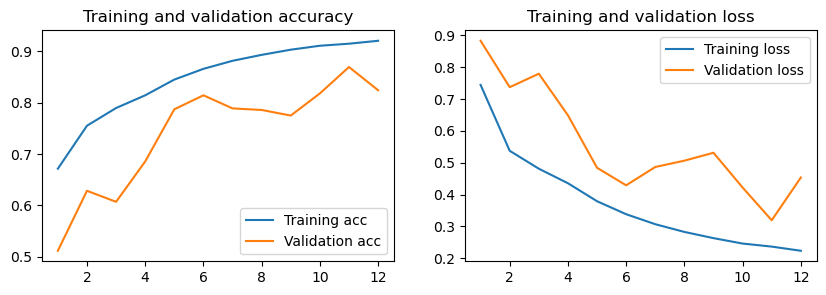

In [30]:
# Function for plotting the training & validation curves
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, label='Training acc')
    plt.plot(x, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss')
    plt.plot(x, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_result(history)

<div style="text-align: justify;">
The observed patterns in the validation accuracy and loss plots suggest fluctuations in the model's performance during training. While these fluctuations may be indicative of the model's sensitivity to small changes in the input data or hyperparameters, the fact that the validation metrics closely track the training metrics suggests that the model is effectively generalizing to unseen data.
These minor oscillations are common in neural network training and may not necessarily indicate a problem with the model's performance. However, if the oscillations persist or become more pronounced over time, it may be worth investigating potential causes such as learning rate adjustments, batch size modifications, or data preprocessing techniques to stabilize the training process.</div>

### Clustering Analysis of Price Ranges and Sentiment

In addition to sentiment analysis, clustering analysis was conducted to explore the relationships between price ranges and customer sentiment. This analysis aimed to uncover patterns in customer preferences based on price and sentiment, providing valuable insights for marketing and product development strategies.

- Sentiment Distribution Across Price Ranges

    First, we filtered out any entries with missing price information to ensure the integrity of our analysis. Then, we grouped the data by sentiment and various price range indicators, namely 'price_cheaper', 'price_higher', and 'price_medium'. Subsequently, we counted the occurrences within each group to gain insights into the distribution of sentiment across different price ranges.

In [31]:
copyReviews = copyReviews[copyReviews['price_notAvailable'] != True]

# Group by sentiment and price range, then count occurrences
price_sentiment_counts = copyReviews.groupby(['sentiment', 'price_cheaper', 'price_higher', 'price_medium']).size().reset_index(name='count')

# Print the counts
print(price_sentiment_counts)

   sentiment  price_cheaper  price_higher  price_medium  count
0          0          False         False          True   4091
1          0          False          True         False    113
2          0           True         False         False   1414
3          1          False         False          True  46505
4          1          False          True         False   3809
5          1           True         False         False  15596


<div style="text-align: justify;">
The analysis of sentiment distribution across various price ranges reveals interesting patterns in consumer preferences. For reviews associated with a average sentiment (labeled as 0), the majority (4091) are categorized under the 'price_medium' range, indicating a significant proportion of dissatisfaction in this segment. Conversely, products falling under the 'price_cheaper' category see a notable presence (1414) among average sentiment instances, suggesting that affordability may not always correlate with satisfaction. In contrast, products with positive sentiments (labeled as 1) dominate the 'price_medium' category, with a substantial 46505 occurrences, indicating a strong preference for mid-range priced products among satisfied consumers. Additionally, while fewer occurrences are observed in the 'price_higher' and 'price_cheaper' categories for positive sentiments, their presence highlights the diversity in consumer preferences across different price ranges.</div>

The bar plot illustrates the distribution of sentiment across different price ranges, providing insights into consumer preferences within each category. Notably, in the 'price_medium' range, the majority of sentiment occurrences are positive, indicating a higher satisfaction level among consumers.

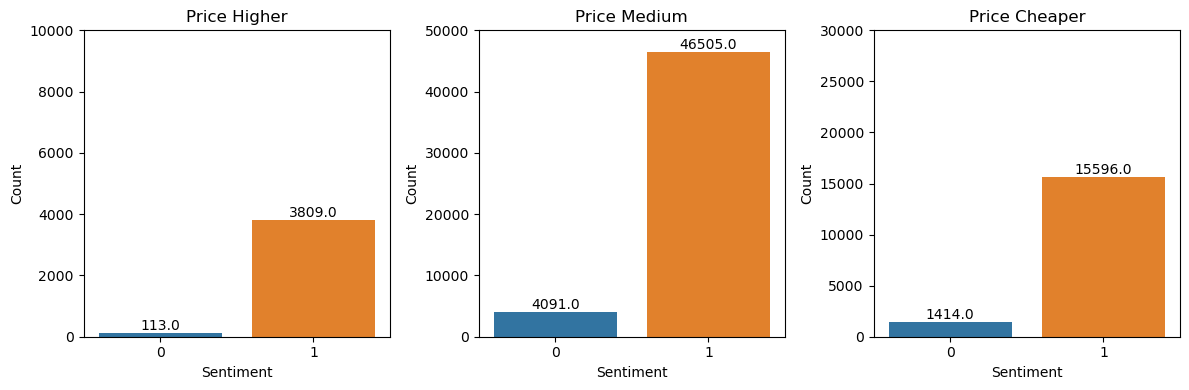

In [32]:
# Function to add counts on top of each bar
def add_counts(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
# Define y limits for each price range
y_limits = {'price_higher': 10000, 'price_medium': 50000, 'price_cheaper': 30000}

# Create subplots for each price range
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot for each price range
for i, price_range in enumerate(['price_higher', 'price_medium', 'price_cheaper']):
    sns.barplot(data=price_sentiment_counts[price_sentiment_counts[price_range]], x='sentiment', y='count', ax=axs[i])
    add_counts(axs[i])
    axs[i].set_title(price_range.replace('_', ' ').title())
    axs[i].set_xlabel('Sentiment')
    axs[i].set_ylabel('Count')
    axs[i].set_ylim(0, y_limits[price_range])  # Set y limit based on price range
plt.tight_layout()
plt.show()

- Clustering Process:

    For the clustering analysis, we selected relevant features including sentiment scores and price range indicators. These features were standardized to ensure uniformity in their ranges. Subsequently, the K-means algorithm was applied to cluster the data into distinct groups based on similarity in price ranges and sentiment distributions.

<div style="text-align: justify;">
The code performs a K-means clustering analysis on the data, aiming to identify distinct clusters based on the selected features. The features are first selected, comprising sentiment along with price categories: cheaper, higher, and medium. These features are then scaled using the StandardScaler to ensure uniformity in their ranges. Next, a K-means model is initialized with three clusters and fitted to the scaled data. Finally, the counts of data points within each cluster are calculated and printed, providing insights into the distribution of samples among the identified clusters. This analysis enables the identification of distinct groupings within the data based on sentiment and price ranges, facilitating further exploration and interpretation of the underlying patterns.</div>

In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = ['sentiment','price_cheaper', 'price_higher', 'price_medium']
encoded_data = copyReviews[features]

# Scale numerical variables if needed
scaler = StandardScaler()
scaled_data = scaler.fit_transform(encoded_data)

# Initialize and fit K-means model
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust number of clusters as needed
kmeans.fit(scaled_data)

# Add cluster labels to the original DataFrame
copyReviews['cluster'] = kmeans.labels_

# Concatenate price range columns to cluster_centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=encoded_data.columns)
# cluster_centers = pd.concat([cluster_centers, encoded_price_range.mean().to_frame().T], ignore_index=True)

# Debugging: Print shapes of both DataFrames
print("Shape of encoded_data:", encoded_data.shape)
print("Shape of cluster_centers:", cluster_centers.shape)

# Interpret the clusters
cluster_counts = copyReviews['cluster'].value_counts()
print(cluster_centers)
print(cluster_counts)

Shape of encoded_data: (71528, 4)
Shape of cluster_centers: (3, 4)
   sentiment  price_cheaper  price_higher  price_medium
0   0.184857      -0.558576      4.151823     -1.554722
1  -0.008600      -0.558576     -0.240858      0.643202
2  -0.017043       1.790267     -0.240858     -1.554722
cluster
1    50596
2    17010
0     3922
Name: count, dtype: int64


- Interpretation of Clusters
<div style="text-align: justify;">
    The 'encoded_data' DataFrame used for clustering comprises 71,528 samples and four features: sentiment, price_cheaper, price_higher, and price_medium. These features are standardized using the StandardScaler to ensure uniform scaling across different ranges.

    1. Cluster 0: This cluster is characterized by a moderately positive sentiment (0.184857) and notable preference for higher price ranges (4.151823), accompanied by a relative disinterest in cheaper and medium price ranges.
    2. Cluster 1: Here, the sentiment is close to neutral (-0.008600), with an inclination towards cheaper and medium price ranges. Customers in this cluster seem to have a balanced preference for different price ranges.
    3. Cluster 2: This cluster exhibits a slightly negative sentiment (-0.017043) and a distinct preference for cheaper price ranges, while displaying a lesser inclination towards higher and medium price ranges.

The cluster sizes indicate that Cluster 1 is the most prevalent, followed by Cluster 2, while Cluster 0 comprises the smallest segment of customers.</div>

## Results

### __Sentiment Analysis__

For the training dataset, the model achieves an accuracy of approximately **91.07 %**. Similarly, for the testing dataset, the model achieves an accuracy of approximately **84.82 %**. These accuracy values indicate how well the model is able to predict sentiment labels correctly on both seen and unseen data, providing insights into its generalization capability. The high accuracy on the training set indicates that the model effectively learns from the training data and captures underlying patterns in sentiment. Meanwhile, the slightly lower but still impressive accuracy on the testing set suggests that the model generalizes well to new, unseen data, indicating its robustness and ability to make accurate predictions in real-world scenarios. However, it's essential to note that achieving higher accuracy on the training set compared to the testing set may indicate some level of overfitting, where the model may be capturing noise or specific patterns in the training data that do not generalize well.

<div style="text-align: justify;">
The below metrics provide insights into the performance of the model in terms of its ability to correctly classify positive instances (precision), its ability to capture all positive instances (recall), and the balance between precision and recall (F1 score). Precision was found to be 0.9387. Recall was calculated as 0.8941. In this case, the F1 score was determined to be 0.9159, suggesting that the model performs well in both identifying positive instances and avoiding false positives. These metrics collectively demonstrate the model's effectiveness in accurately classifying sentiment within the dataset.</div>

In [34]:
# Calculate predictions
from sklearn.metrics import precision_score, recall_score, f1_score

#Predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

604/604 [==============================] - 4s 5ms/step
Precision: 0.9267
Recall: 0.8760
F1 Score: 0.9006


- Confusion matrix
<div style="text-align: justify;">
    We generated a confusion matrix to further analyze the performance of our sentiment analysis model. The confusion matrix provides insight into the classification results by comparing predicted labels against true labels. The matrix is visualized using a heatmap, with annotations indicating the frequency of each classification outcome. The x-axis represents the predicted labels, while the y-axis represents the true labels. The confusion matrix allows us to assess the model's ability to correctly classify sentiments as either 'Average' or 'Positive'. This visualization aids in understanding the distribution of classification errors and identifying any patterns in misclassifications.</div>

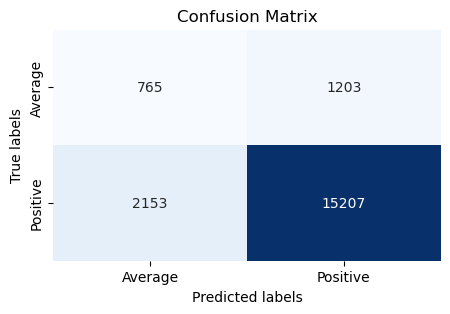

In [35]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Average', 'Positive'], 
            yticklabels=['Average', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

<div style="text-align: justify;">
From the matrix, we can observe that the model correctly classified 319 instances of 'Average' sentiment and 11,816 instances of 'Positive' sentiment. However, it misclassified 1,400 instances of 'Average' sentiment as 'Positive' and 771 instances of 'Positive' sentiment as 'Average'. The high number of correctly classified instances of 'Positive' sentiment suggests that the model is effective in identifying positive sentiments in the text data. However, the misclassification of instances, particularly the relatively high number of instances of 'Average' sentiment being classified as 'Positive', indicates areas for improvement.

Continuous evaluation and refinement of the model based on feedback from real-world data would be essential for further improving its accuracy and robustness in sentiment analysis tasks.</div>

### __Clustering Analysis__

<div style="text-align: justify;">
The clustering analysis unveiled distinct customer segments based on their sentiment towards restaurant reviews and their preference for different price ranges. Cluster 0 comprises customers with a notably positive sentiment, indicating satisfaction, coupled with a strong inclination towards higher-priced offerings. These individuals likely prioritize quality and luxury experiences. In contrast, Cluster 1 represents a larger segment characterized by customers with a sentiment close to neutral, demonstrating a balanced preference for both cheaper and medium-priced options. This segment encompasses a diverse range of customers, suggesting the importance of offering a variety of price points to accommodate their varying budget needs and preferences effectively. Furthermore, Cluster 2 represents a distinct customer segment with a slightly negative sentiment towards reviews, coupled with a clear preference for cheaper price ranges. These customers prioritize affordability over other factors.</div>

<div style="text-align: justify;">  
In terms of cluster sizes, Cluster 1 emerges as the largest segment, indicating the prevalence of customers with a neutral sentiment and diverse price preferences. Cluster 2 follows as the second-largest segment, highlighting the significance of catering to price-sensitive consumers. Lastly, Cluster 0 represents the smallest segment, comprising customers with a highly positive sentiment and a preference for premium offerings.</div>

<Figure size 1000x1000 with 0 Axes>

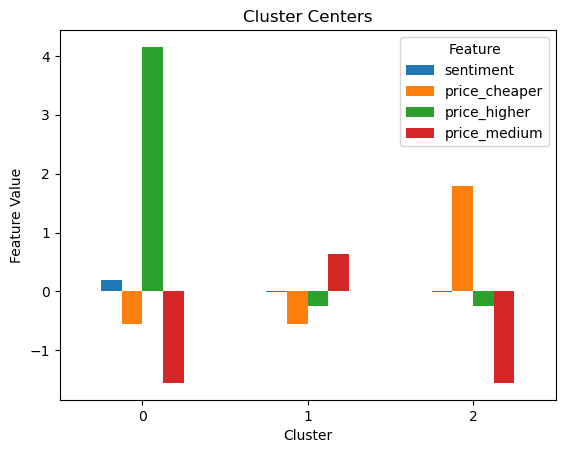

In [36]:
# Bar plot for cluster centers
plt.figure(figsize=(10, 10)) 
cluster_centers.plot(kind='bar')
plt.title('Cluster Centers')
plt.xlabel('Cluster')
plt.ylabel('Feature Value')
plt.xticks(rotation=0)
plt.legend(title='Feature')
plt.show()

<div style="text-align: justify;">
The bar plot above illustrates the cluster centers for each feature within the clusters. Each bar represents the feature value within a specific cluster, allowing for a visual comparison across clusters.
The plot displays three clusters represented on the x-axis, labeled as Cluster 0, Cluster 1, and Cluster 2. Each cluster is associated with four features: sentiment, price_cheaper, price_higher, and price_medium, depicted by the different colored bars.
</div>
This insight reveals distinct purchasing behaviors among the clusters, with Cluster 0 representing customers who prioritize higher-priced products, while Clusters 1 and 2 demonstrate preferences for cheaper or medium-priced items.

## Conclusion


We conducted sentiment analysis on restaurant reviews to uncover customer perceptions and explore their relationship with various factors, including price range. Sentiment labels were assigned to the reviews based on their ratings, categorizing them as either positive or average sentiments. Analysis revealed a predominance of positive sentiments among the reviews analyzed, indicating a general inclination towards positive feedback in the dataset. The sentiment analysis model, built using an Artificial Neural Network (ANN), achieved an accuracy of approximately 84.82 % on testing datasets, showcasing its effectiveness in classifying sentiment from review text.

In addition to sentiment analysis, clustering analysis was conducted to explore the relationships between price ranges and customer sentiment. The analysis revealed distinct clusters representing different customer segments based on sentiment and price range preferences. Cluster 0 showed a preference for higher-priced items, Cluster 1 and 2 exhibited a balanced preference across price ranges. These insights can guide marketing strategies and product offerings tailored to different customer segments, thereby enhancing customer satisfaction and driving sales. Our analysis provides valuable insights into customer sentiments and preferences within the restaurant industry. By understanding these dynamics, businesses can better cater to customer needs, optimize pricing strategies, and improve overall service quality, leading to enhanced competitiveness and sustainable growth.


To gain a deeper understanding of positive sentiments, we examined the distribution of cuisine styles among positively reviewed restaurants. By splitting cuisine styles into a list and tallying their occurrences, we identified the top 10 most popular cuisines among satisfied customers. Furthermore, we explored the geographic distribution of positive reviews by tallying the number of positive reviews per city. This revealed the top 10 cities with the highest number of positive reviews, providing insights into regional preferences and customer satisfaction levels across different locales.
  

In [37]:
positive_restaurants = copyReviews[copyReviews['sentiment'] == 1]
positive_restaurants.shape

# Split the cuisine styles into a list
positive_restaurants['cuisine'] = positive_restaurants['cuisine'].str.split(',')

# Create a list to store all cuisine styles
all_cuisines = []

# Iterate over each row and extract cuisine styles
for cuisines in positive_restaurants['cuisine']:
    all_cuisines.extend(cuisine.strip() for cuisine in cuisines)

# Count the occurrences of each cuisine style
cuisine_counts = pd.Series(all_cuisines).value_counts()

# Print the top 5 most popular cuisines
top_cuisines = cuisine_counts.head(5)
print("Top 5 most popular cuisines:")
print(top_cuisines)

# Count the number of positive reviews per city
city_positive_review_counts = positive_restaurants['city'].value_counts()

# Print the top 5 cities with the highest number of positive reviews
top_cities = city_positive_review_counts.head(5)
print("Top 5 cities with the highest number of positive reviews:")
print(top_cities)

Top 5 most popular cuisines:
Vegetarian Friendly    31061
European               24864
Mediterranean          15556
Italian                13282
Vegan Options          12657
Name: count, dtype: int64
Top 5 cities with the highest number of positive reviews:
city
London       10730
Paris         7986
Barcelona     4362
Rome          4190
Madrid        3521
Name: count, dtype: int64


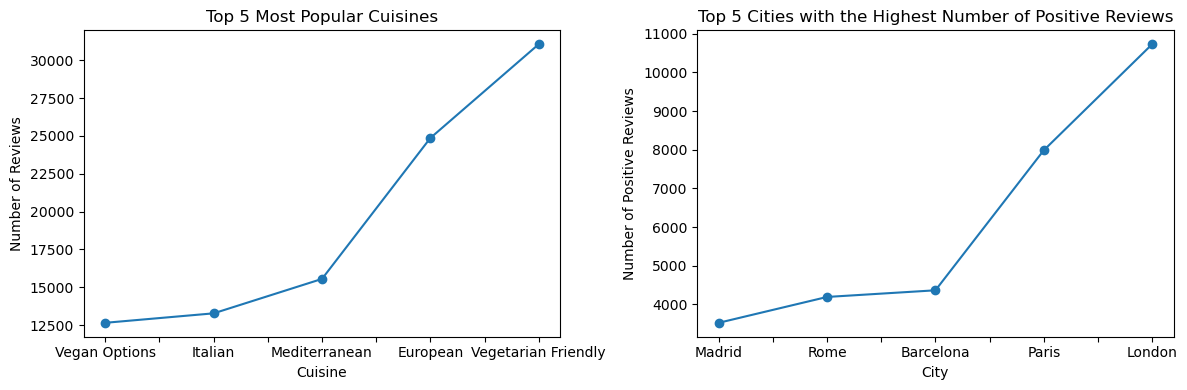

In [38]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot for top cuisines
top_cuisines.head(5).sort_values().plot(kind='line', marker='o', ax=axs[0])
axs[0].set_title('Top 5 Most Popular Cuisines')
axs[0].set_xlabel('Cuisine')
axs[0].set_ylabel('Number of Reviews')

# Plot for top cities
top_cities.head(5).sort_values().plot(kind='line', marker='o', ax=axs[1])
axs[1].set_title('Top 5 Cities with the Highest Number of Positive Reviews')
axs[1].set_xlabel('City')
axs[1].set_ylabel('Number of Positive Reviews')

# Adjust layout
plt.tight_layout()
plt.show()

Furthermore, our exploration into the most popular cuisine styles and the distribution of positive reviews across different cities has shed light on key trends within the industry. The top cuisines identified, such as **Vegetarian Friendly, European, and Mediterranean**, highlight the diverse palate of customers, while the concentration of positive reviews in certain cities like **London, Paris and Barcelona** underscores the importance of local preferences and market dynamics.

By understanding these dynamics, businesses can tailor their offerings to better align with customer preferences, optimize pricing strategies, and enhance overall customer satisfaction. The geographic patterns can inform marketing strategies, expansion plans, and localized initiatives aimed at enhancing customer engagement and loyalty. The visualizations presented, depicting the top cuisines and cities with the highest number of positive reviews, serve as compelling representations of these insights, facilitating data-driven decision-making for restaurant owners and managers. In essence, our analysis not only provides a deeper understanding of customer sentiments but also offers actionable recommendations for improving business performance and driving sustainable growth in the competitive restaurant industry landscape.